## EM Algorithm

- **Observables**: $x, y, \hat z$
- **Latent**: $z$
- **Model**:
    - $p(z)$: prior over latent $z$
    - $p(\hat z | z)$: observation model for $\hat z$
    - $p(y|z,x,\theta)$: likelihood model for $y$ parameterized by $\theta$ and conditioned on $z$ and $x$

The marginal likelihood is
\begin{align}
p(y|x,\hat z,\theta) &= \int p(y,z|x,\hat z,\theta) dz\\
&= \frac{\int p(y|z,x,\theta)p(\hat z|z)p(z)dz}{\int p(\hat z|z)p(z)dz}
\end{align}

- **E-step**: Infer latent variable $z$ based on current guess of parameters:
$$q(z) \leftarrow p(z|x,y,\hat z,\theta) \propto p(z)p(y,\hat z|z,\theta,x) = p(y|z,x,\theta)p(\hat z|z)p(z)$$
<!-- - **M-step**: $\theta = \text{argmax}_\theta\mathbb{E}_{q(z)}[p(y|z,x,\theta)p(\hat z|z)]$ -->
- **M-step**: Update parameters $\theta$ to maximize the expected log-likelihood of the observed data under that inferred $q(z)$:
$$\theta = \text{argmax}_\theta\mathbb{E}_{q(z)}[\log p(y|z,x,\theta)]$$

In [1]:
# Given:
# function model_lkhd(x, y, z, theta) = p(y|z,x,theta)
# grid size = [H, W]

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

# Set MPS fallback to enable operations not supported natively on Apple Silicon
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import bopt
import h5py as h5
import utils

In [3]:
sample_rate = 50
device = bopt.cuda_init()  # Using specific GPU
# device='cuda:7'
samplerate = 50
num_before = 25
num_after = 5
seed = 2222
torch.random.manual_seed(seed)

--- device:0 has 1
--- device:1 has 1
--- device:2 has 3
--- device:3 has 1
--- device:4 has 1
--- device:5 has 1
--- device:6 has 0
--- device:7 has 0
Selected device: cuda:6


In [4]:
# Let's first load the h5 and see what's inside
h5_filepath = '/home/sunnyliu1220/git/latent-gaze/data/charm_50_rec_reduced.h5'
# charmander_clusters= [ 4, 15, 41, 42, 43, 50, 62, 107, 121, 168, 225, 226, 245, 251, 259, 261,
#     263, 271, 282, 294, 302, 327, 334, 340, 342, 347, 363, 364, 367, 375, 400,
#     555
# ]
charmander_clusters= [ 107, 124, 145, 154, 168, 225, 226, 247, 251, 261, 263, 271, 302, 309, 327, 334, 340, 342, 345, 363, 364, 375, 380, 555
] # From Zaki's leghorn charmander_shifted_neuralcollapse



In [5]:
# Let's verify the contents of our newly created H5 file
with h5.File(h5_filepath, 'r') as f:
    # Print the high-level structure
    print("Keys in the reduced h5 file:", list(f.keys()))
    
    # Check data structure
    print("\nData structure:")
    for series_key in f['data'].keys():
        print(f"  Series: {series_key}")
        for epoch_key in f['data'][series_key].keys():
            print(f"    Epoch: {epoch_key}")
            for group_key in f['data'][series_key][epoch_key].keys():
                print(f"      Group: {group_key}")
    
    # Check metadata
    print("\nMetadata structure:")
    for meta_key in f['meta'].keys():
        print(f"  {meta_key}")
    
    # Check file size
    import os
    print(f"\nFile size: {os.path.getsize(h5_filepath) / (1024*1024):.2f} MB")

Keys in the reduced h5 file: ['data', 'meta']

Data structure:
  Series: series_008
    Epoch: epoch_001
      Group: firing_rates
      Group: signals
      Group: stimulus
  Series: series_009
    Epoch: epoch_001
      Group: firing_rates
      Group: signals
      Group: stimulus

Metadata structure:
  cluster_ids
  reconstruction

File size: 636.14 MB


In [6]:
direction='shifted'
# test_series = ['series_008/epoch_001', 'series_009/epoch_001']
test_series = ['series_008/epoch_001']
test_idxs = [-samplerate * 10, -1]
test_all = [0, -1]

test_dataset_shifted = bopt.CorticalDataset(h5_filepath,
                                    test_series,
                                    num_before=num_before,
                                    num_after=num_after,
                                    start_idx=test_all[0],
                                    end_idx=test_all[1],
                                    stimulus_key='shifted',
                                    grayscale=True,
                                    normalize_signals=False,
                                    signals=['locomotion', 'azimuth'],
                                    which_clusters=charmander_clusters,
                                    zero_blinks=True)

test_loader_shifted = torch.utils.data.DataLoader(test_dataset_shifted,
                                          batch_size=256,
                                          shuffle=False)


Zeroing out blinks in stimulus (at init).


In [7]:
model_path = '/home/sunnyliu1220/git/latent-gaze/models/final_model.pt'
# Load the model
model = torch.load(model_path, map_location=device)
model.to(device)  # Explicitly move model to the device
model.eval()

/tmp/ipykernel_1047914/78538957.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


CNNComponent(
  (layers): ModuleDict(
    (conv0): Conv2d(30, 24, kernel_size=(7, 7), stride=(1, 1), padding=valid)
    (layernorm0): LayerNorm((24, 62, 96), eps=1e-05, elementwise_affine=False)
    (dropout0): Dropout(p=0.1, inplace=False)
    (nl0): Softplus(beta=1.0, threshold=20.0)
    (conv1): Conv2d(24, 24, kernel_size=(7, 7), stride=(1, 1), padding=valid)
    (layernorm1): LayerNorm((24, 56, 90), eps=1e-05, elementwise_affine=False)
    (dropout1): Dropout(p=0.1, inplace=False)
    (nl1): Softplus(beta=1.0, threshold=20.0)
    (conv2): Conv2d(24, 24, kernel_size=(7, 7), stride=(1, 1), padding=valid)
    (layernorm2): LayerNorm((24, 50, 84), eps=1e-05, elementwise_affine=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (nl2): Softplus(beta=1.0, threshold=20.0)
    (conv3): Conv2d(24, 24, kernel_size=(7, 7), stride=(1, 1), padding=valid)
    (layernorm3): LayerNorm((24, 44, 78), eps=1e-05, elementwise_affine=False)
    (dropout3): Dropout(p=0.1, inplace=False)
    (nl3): S

In [8]:
# Let's define our sample
stim = test_dataset_shifted[0][0]
print("Stimulus shape:", stim.shape)
H = stim.shape[1]
W = stim.shape[2]
response = test_dataset_shifted[0][1]
print("Response shape:", response.shape)

Stimulus shape: torch.Size([30, 68, 102])
Response shape: torch.Size([24])


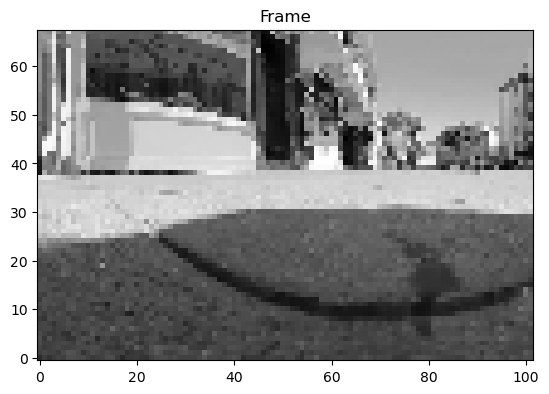

In [9]:
utils.plot_frame(stim[0], flip_y=True, title="Frame")

In [10]:
print("Stimulus shape:", stim[0].unsqueeze(0).shape)

Stimulus shape: torch.Size([1, 68, 102])


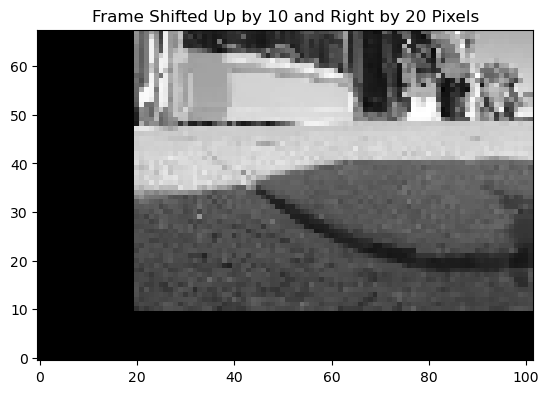

In [11]:
# Shift this frame up by 10 pixels and right by 20 pixels and plot
utils.plot_frame(utils.shift_stimulus(stim[0].unsqueeze(0), torch.tensor([10]), torch.tensor([20])).squeeze(), flip_y=True, title="Frame Shifted Up by 10 and Right by 20 Pixels")

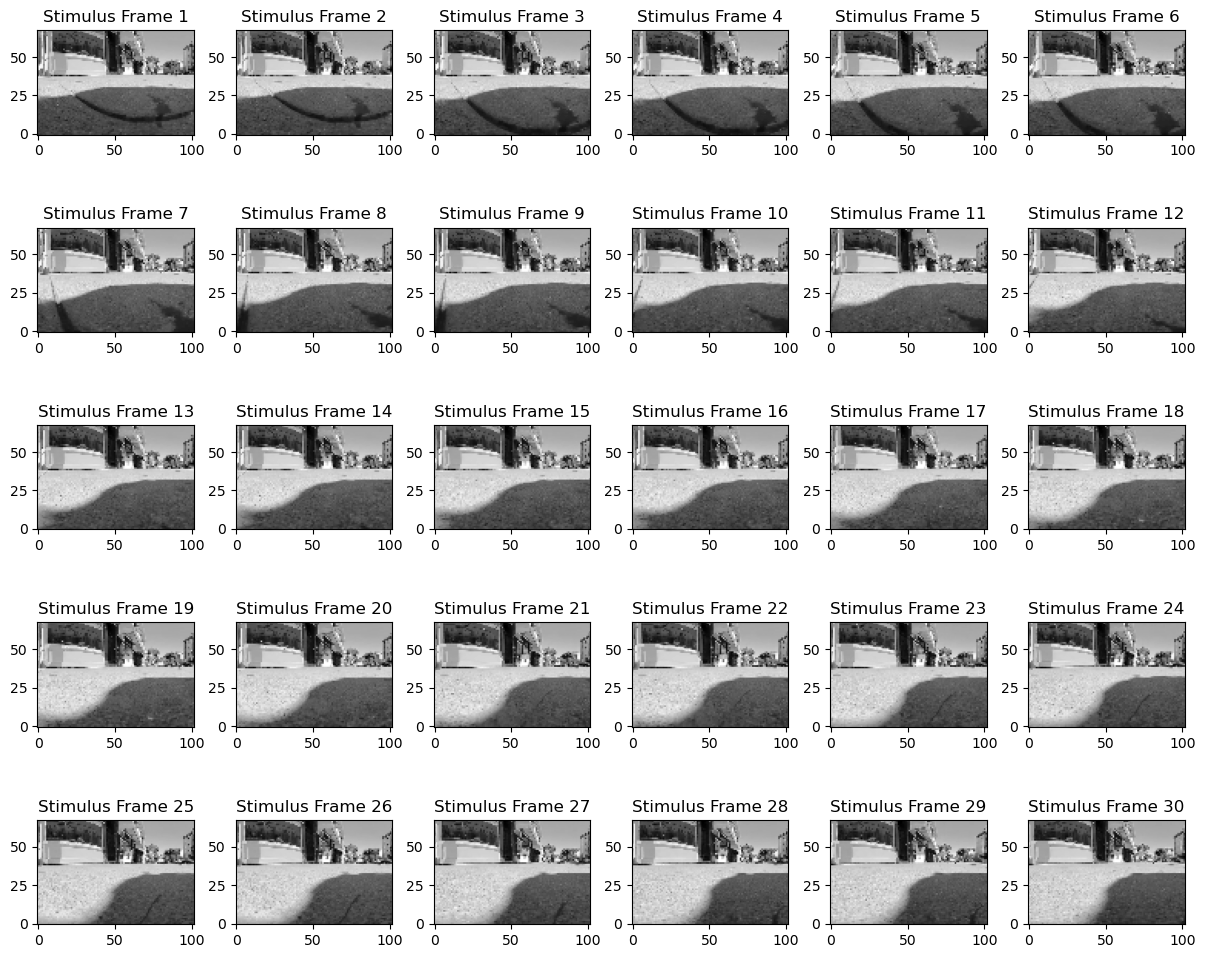

In [12]:
utils.plot_stimulus(stim, flip_y=True, title="Stimulus")

In [13]:
# Display the stimulus as an interactive movie viewer
print(f"Stimulus has {stim.shape[0]} frames")
print("Showing interactive stimulus viewer...")
utils.show_stimulus_movie(stim, flip_y=True, title="Stimulus Movie")

Stimulus has 30 frames
Showing interactive stimulus viewer...
Interactive slider for 30 frames (use slider below to navigate)


interactive(children=(IntSlider(value=0, description='Frame:', max=29), Output()), _dom_classes=('widget-inter…

In [ ]:
# Now, display the whole epoch as a movie
print("Showing interactive epoch movie...")

# Collect all stimuli from the dataset to create the full epoch movie
all_stimuli = []
for i in range(len(test_dataset_shifted)):
    stimulus = test_dataset_shifted[i][0][0:1]  # Get stimulus (first element of tuple)
    all_stimuli.append(stimulus)

# Stack all stimuli into a single tensor
# Each stimulus has shape (num_frames, H, W), so we concatenate along the time dimension
epoch_stimuli = torch.cat(all_stimuli, dim=0)
print(f"Epoch movie shape: {epoch_stimuli.shape} (total_frames, height, width)")
print(f"Total frames in epoch: {epoch_stimuli.shape[0]}")
print(f"Frame size: {epoch_stimuli.shape[1]}x{epoch_stimuli.shape[2]}")

# Display the entire epoch as an interactive movie
utils.show_stimulus_movie(epoch_stimuli, flip_y=True, title="Complete Epoch Movie")

Showing interactive epoch movie...
Epoch movie shape: torch.Size([966, 68, 102]) (total_frames, height, width)
Total frames in epoch: 966
Frame size: 68x102
Interactive slider for 966 frames (use slider below to navigate)


interactive(children=(IntSlider(value=0, description='Frame:', max=965), Output()), _dom_classes=('widget-inte…

In [14]:
# Let's estimate the variance of each neuron's response
all_responses = []
for i in range(len(test_dataset_shifted)):
    response = test_dataset_shifted[i][1]
    all_responses.append(response)
all_responses = torch.stack(all_responses, dim=0)
print("All responses shape:", all_responses.shape)

# Calculate the variance for each neuron across all samples
neuron_variances = torch.var(all_responses, dim=0)
print("Neuron variances shape:", neuron_variances.shape)
print ("Neuron variances:", neuron_variances)
var_mean = torch.mean(neuron_variances, dim=0)
print("All mean:", var_mean)

All responses shape: torch.Size([966, 24])
Neuron variances shape: torch.Size([24])
Neuron variances: tensor([0.0000e+00, 3.5875e+00, 5.6214e+01, 1.2472e+01, 1.0044e+02, 4.3521e+01,
        1.1881e+02, 1.0439e+02, 8.2785e+00, 2.7290e+02, 7.1644e+01, 1.2826e+02,
        2.1721e+02, 1.0541e+01, 4.2568e+02, 2.5419e+01, 1.3517e+02, 9.3341e+02,
        3.5047e+01, 7.2821e-01, 1.7322e+01, 5.6755e+00, 7.7601e+00, 4.2297e+02],
       dtype=torch.float64)
All mean: tensor(131.5602, dtype=torch.float64)


In [15]:
# Let's run a full EM algorithm.
q_z_prior = torch.ones((H, W), device=device) / (H * W)  # Uniform prior over pixels
z_hat = torch.tensor([H/2-0.5, W/2-0.5], device=device)  # Put z_hat on the correct device

In [16]:
# Run the complete EM algorithm
print("Running complete EM algorithm...")
print(f"Initial data shapes - Stimulus: {stim.shape}, Response: {response.shape}")
print(f"Grid size: {H}x{W}")
print(f"z_hat (eye position estimate): {z_hat}")

# Set up parameters for EM
EM_steps = 3  # Number of EM iterations
train_steps = 5  # Number of training steps per M-step
initial_lr = 1e-3  # Initial learning rate
sigma = 2.0  # Standard deviation for Gaussian likelihood p(z_hat | z)

# Run the EM algorithm
posteriors, log_lkhds, log_p_z_hat_given_z_list, updated_model, all_elbos = utils.run_EM(
    x=stim,
    y=response, 
    z_hat=z_hat,
    model=model,
    q_z_prior=q_z_prior,
    sigma=sigma,
    y_var=var_mean.item(),  # Use the computed variance
    batch_size=256,
    EM_steps=EM_steps,
    train_steps=train_steps,
    lr=initial_lr,
    device=device
)

print(f"\nEM algorithm completed!")
print(f"Number of posterior distributions stored: {len(posteriors)}")
print(f"Number of log likelihood arrays stored: {len(log_lkhds)}")
print(f"Number of log p(z_hat | z) arrays stored: {len(log_p_z_hat_given_z_list)}")
print(f"Total ELBO values collected: {len(all_elbos)}")

Running complete EM algorithm...
Initial data shapes - Stimulus: torch.Size([30, 68, 102]), Response: torch.Size([24])
Grid size: 68x102
z_hat (eye position estimate): tensor([33.5000, 50.5000], device='cuda:0')

EM Step 1/3
z_hat (eye position estimate): tensor([33.5000, 50.5000], device='cuda:0')

EM Step 1/3
Step 1/5, Loss: 12.7848
Step 1/5, Loss: 12.7848
Step 2/5, Loss: 1.8928
Step 2/5, Loss: 1.8928
Step 3/5, Loss: 0.6836
Step 3/5, Loss: 0.6836
Step 4/5, Loss: 0.3903
Step 4/5, Loss: 0.3903
Step 5/5, Loss: 0.2287
Updated learning rate: 0.001000

EM Step 2/3
Step 5/5, Loss: 0.2287
Updated learning rate: 0.001000

EM Step 2/3
Step 1/5, Loss: 0.5179
Step 1/5, Loss: 0.5179
Step 2/5, Loss: 16.4996
Step 2/5, Loss: 16.4996
Step 3/5, Loss: 1.4174
Step 3/5, Loss: 1.4174
Step 4/5, Loss: 0.4277
Step 4/5, Loss: 0.4277
Step 5/5, Loss: 0.0451
Updated learning rate: 0.000200

EM Step 3/3
Step 5/5, Loss: 0.0451
Updated learning rate: 0.000200

EM Step 3/3
Step 1/5, Loss: 0.1394
Step 1/5, Loss: 0.13

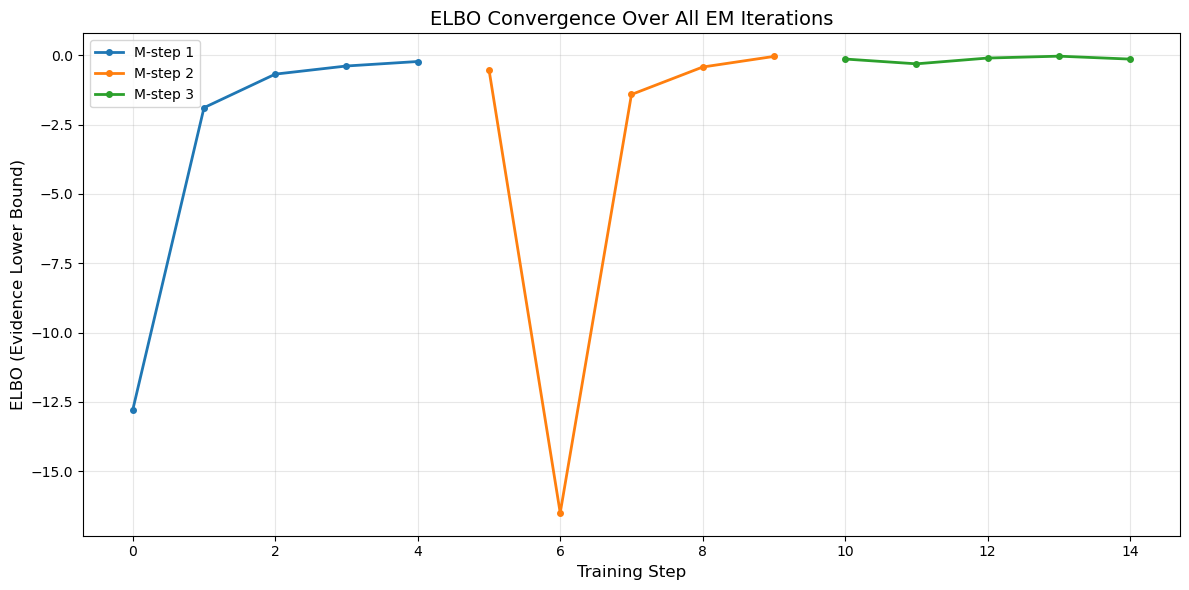

Initial ELBO: -12.7848
Final ELBO: -0.1416
Total improvement: 12.6432


In [ ]:
# Plot ELBO convergence over all EM iterations
plt.figure(figsize=(12, 6))

# Split the ELBO values into 3 M-steps with 5 training steps each
for m_step in range(3):
    start_idx = m_step * 5
    end_idx = (m_step + 1) * 5
    x_values = range(start_idx, end_idx)
    y_values = all_elbos[start_idx:end_idx]
    
    plt.plot(x_values, y_values, marker='o', linewidth=2, markersize=4, 
             label=f'M-step {m_step + 1}')

plt.title('ELBO Convergence Over All EM Iterations', fontsize=14)
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('ELBO (Evidence Lower Bound)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial ELBO: {all_elbos[0]:.4f}")
print(f"Final ELBO: {all_elbos[-1]:.4f}")
print(f"Total improvement: {all_elbos[-1] - all_elbos[0]:.4f}")

E-step 1: sum=1.000000, max=0.090236
E-step 2: sum=1.000000, max=0.094145
E-step 3: sum=1.000000, max=0.255669
E-step 4: sum=1.000000, max=0.321532


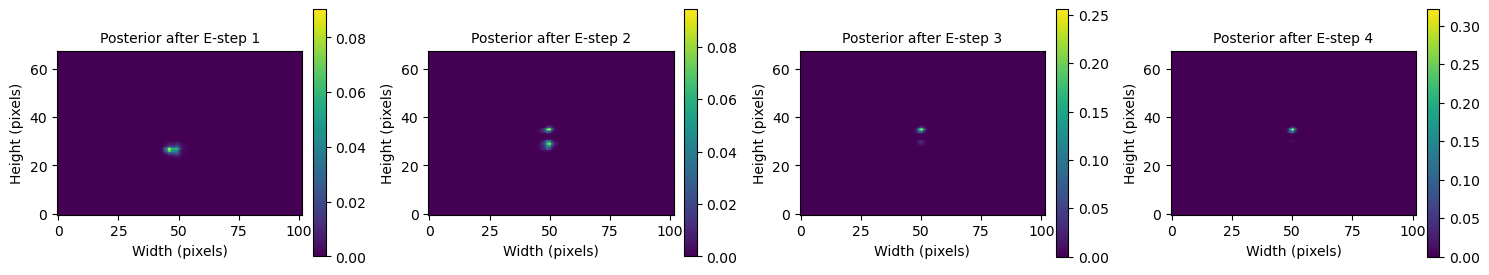

In [18]:
# Visualize the evolution of posterior distributions
fig, axes = plt.subplots(1, len(posteriors), figsize=(15, 4))
if len(posteriors) == 1:
    axes = [axes]  # Ensure axes is always a list

for i, posterior in enumerate(posteriors):
    if i < len(axes):
        im = axes[i].imshow(posterior.cpu().numpy(), cmap='viridis')
        axes[i].set_title(f'Posterior after E-step {i+1}', fontsize=10)
        axes[i].invert_yaxis()  # Flip y-axis to match previous plots
        axes[i].set_xlabel('Width (pixels)')
        axes[i].set_ylabel('Height (pixels)')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        
        # Print statistics for each posterior
        print(f"E-step {i+1}: sum={posterior.sum().item():.6f}, max={posterior.max().item():.6f}")

# Hide unused subplots
for i in range(len(posteriors), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

E-step 1: max_log_lkhd=-2.10, mean_log_lkhd=-13.30
E-step 2: max_log_lkhd=-0.50, mean_log_lkhd=-0.51
E-step 3: max_log_lkhd=-0.14, mean_log_lkhd=-0.14
E-step 4: max_log_lkhd=-0.14, mean_log_lkhd=-0.14


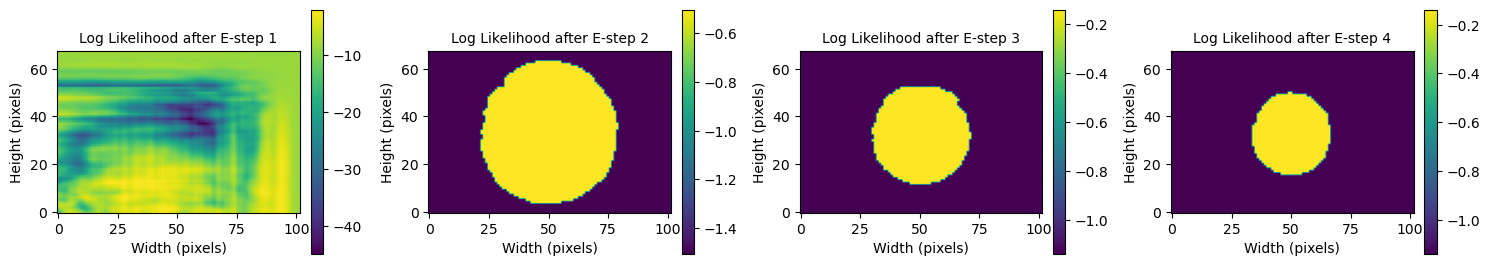


Log Likelihood Evolution Summary:
E-step 1: Max=-2.10, Mean=-13.30, Std=8.20
E-step 2: Max=-0.50, Mean=-0.51, Std=0.00
E-step 3: Max=-0.14, Mean=-0.14, Std=0.00
E-step 4: Max=-0.14, Mean=-0.14, Std=0.00


In [19]:
# Visualize the evolution of log likelihoods over EM steps
fig, axes = plt.subplots(1, len(log_lkhds), figsize=(15, 4))
if len(log_lkhds) == 1:
    axes = [axes]  # Ensure axes is always a list

for i, log_lkhd in enumerate(log_lkhds):
    if i < len(axes):
        # Reshape log likelihood to 2D grid
        log_lkhd_2d = log_lkhd.reshape(H, W).cpu().numpy()
        
        # Handle -inf values for better visualization
        log_lkhd_display = log_lkhd_2d.copy()
        finite_mask = np.isfinite(log_lkhd_display)
        if finite_mask.any():
            min_finite = log_lkhd_display[finite_mask].min()
            log_lkhd_display[~finite_mask] = min_finite - 1
        
        im = axes[i].imshow(log_lkhd_display, cmap='viridis')
        axes[i].set_title(f'Log Likelihood after E-step {i+1}', fontsize=10)
        axes[i].invert_yaxis()  # Flip y-axis to match previous plots
        axes[i].set_xlabel('Width (pixels)')
        axes[i].set_ylabel('Height (pixels)')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        
        # Print statistics for each log likelihood
        finite_values = log_lkhd[torch.isfinite(log_lkhd)]
        if len(finite_values) > 0:
            print(f"E-step {i+1}: max_log_lkhd={finite_values.max().item():.2f}, mean_log_lkhd={finite_values.mean().item():.2f}")
        else:
            print(f"E-step {i+1}: No finite log likelihood values")

# Hide unused subplots
for i in range(len(log_lkhds), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Show improvement in log likelihood concentration
print("\nLog Likelihood Evolution Summary:")
for i, log_lkhd in enumerate(log_lkhds):
    finite_values = log_lkhd[torch.isfinite(log_lkhd)]
    if len(finite_values) > 0:
        max_val = finite_values.max().item()
        mean_val = finite_values.mean().item()
        std_val = finite_values.std().item()
        print(f"E-step {i+1}: Max={max_val:.2f}, Mean={mean_val:.2f}, Std={std_val:.2f}")
    else:
        print(f"E-step {i+1}: No finite values")

E-step 1: max_log_p=-3.29, mean_log_p=-159.74
E-step 2: max_log_p=-3.29, mean_log_p=-57.76
E-step 3: max_log_p=-3.29, mean_log_p=-30.55
E-step 4: max_log_p=-3.29, mean_log_p=-21.46
E-step 3: max_log_p=-3.29, mean_log_p=-30.55
E-step 4: max_log_p=-3.29, mean_log_p=-21.46


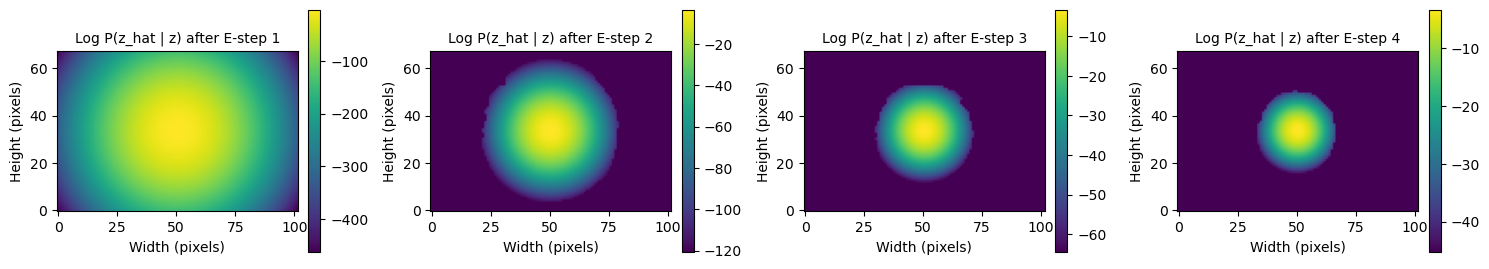


Log P(z_hat | z) Evolution Summary:
E-step 1: Max=-3.29, Mean=-159.74, Std=106.05
E-step 2: Max=-3.29, Mean=-57.76, Std=31.65
E-step 3: Max=-3.29, Mean=-30.55, Std=16.01
E-step 4: Max=-3.29, Mean=-21.46, Std=10.71


In [20]:
# Visualize the evolution of log p(z_hat | z) over EM steps
fig, axes = plt.subplots(1, len(log_p_z_hat_given_z_list), figsize=(15, 4))
if len(log_p_z_hat_given_z_list) == 1:
    axes = [axes]  # Ensure axes is always a list

for i, log_p_z_hat_given_z in enumerate(log_p_z_hat_given_z_list):
    if i < len(axes):
        # Reshape log p(z_hat | z) to 2D grid
        log_p_z_hat_given_z_2d = log_p_z_hat_given_z.reshape(H, W).cpu().numpy()
        
        # Handle -inf values for better visualization
        log_p_display = log_p_z_hat_given_z_2d.copy()
        finite_mask = np.isfinite(log_p_display)
        if finite_mask.any():
            min_finite = log_p_display[finite_mask].min()
            log_p_display[~finite_mask] = min_finite - 1
        
        im = axes[i].imshow(log_p_display, cmap='viridis')
        axes[i].set_title(f'Log P(z_hat | z) after E-step {i+1}', fontsize=10)
        axes[i].invert_yaxis()  # Flip y-axis to match previous plots
        axes[i].set_xlabel('Width (pixels)')
        axes[i].set_ylabel('Height (pixels)')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        
        # Print statistics for each log p(z_hat | z)
        finite_values = log_p_z_hat_given_z[torch.isfinite(log_p_z_hat_given_z)]
        if len(finite_values) > 0:
            print(f"E-step {i+1}: max_log_p={finite_values.max().item():.2f}, mean_log_p={finite_values.mean().item():.2f}")
        else:
            print(f"E-step {i+1}: No finite log p(z_hat | z) values")

# Hide unused subplots
for i in range(len(log_p_z_hat_given_z_list), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Show summary of log p(z_hat | z) evolution
print("\nLog P(z_hat | z) Evolution Summary:")
for i, log_p_z_hat_given_z in enumerate(log_p_z_hat_given_z_list):
    finite_values = log_p_z_hat_given_z[torch.isfinite(log_p_z_hat_given_z)]
    if len(finite_values) > 0:
        max_val = finite_values.max().item()
        mean_val = finite_values.mean().item()
        std_val = finite_values.std().item()
        print(f"E-step {i+1}: Max={max_val:.2f}, Mean={mean_val:.2f}, Std={std_val:.2f}")
    else:
        print(f"E-step {i+1}: No finite values")

In [21]:
# Reload the original model (before EM training)
model_path = '/home/sunnyliu1220/git/latent-gaze/models/final_model.pt'
original_model = torch.load(model_path, map_location=device)
original_model.to(device)
original_model.eval()

# Now let's do E step on all the test data using the original model
print(f"Dataset length: {len(test_dataset_shifted)}")
print(f"Running E-step on all {len(test_dataset_shifted)} samples...")

# Create indices for all samples in the dataset
all_indices = list(range(len(test_dataset_shifted)))

# Run batch E-step on all test data using the ORIGINAL model
all_posteriors, all_log_lkhds, all_log_p_z_hat_given_z = utils.batch_E_step(
    indices=all_indices,
    dataset=test_dataset_shifted,
    model=original_model,  # Using original model, not the EM-updated one
    z_hat=z_hat,
    q_z_prior=q_z_prior,
    sigma=sigma,
    y_var=var_mean.item(),
    device=device
)

print(f"\nBatch E-step completed!")
print(f"Results shape:")
print(f"  Posteriors: {all_posteriors.shape}")
print(f"  Log likelihoods: {all_log_lkhds.shape}")
print(f"  Log p(z_hat | z): {all_log_p_z_hat_given_z.shape}")


Dataset length: 966
Running E-step on all 966 samples...
Running batch E-step for 966 samples...
Processing sample 1/966 (dataset index 0)


/tmp/ipykernel_1034301/2882296512.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_model = torch.load(model_path, map_location=device)


  Posterior sum: 1.000000, max: 0.068153
Processing sample 2/966 (dataset index 1)
  Posterior sum: 1.000000, max: 0.077824
Processing sample 3/966 (dataset index 2)
  Posterior sum: 1.000000, max: 0.077824
Processing sample 3/966 (dataset index 2)
  Posterior sum: 1.000000, max: 0.065514
Processing sample 4/966 (dataset index 3)
  Posterior sum: 1.000000, max: 0.065514
Processing sample 4/966 (dataset index 3)
  Posterior sum: 1.000000, max: 0.041952
Processing sample 5/966 (dataset index 4)
  Posterior sum: 1.000000, max: 0.041952
Processing sample 5/966 (dataset index 4)
  Posterior sum: 1.000000, max: 0.054947
Processing sample 6/966 (dataset index 5)
  Posterior sum: 1.000000, max: 0.054947
Processing sample 6/966 (dataset index 5)
  Posterior sum: 1.000000, max: 0.049639
Processing sample 7/966 (dataset index 6)
  Posterior sum: 1.000000, max: 0.049639
Processing sample 7/966 (dataset index 6)
  Posterior sum: 1.000000, max: 0.066392
Processing sample 8/966 (dataset index 7)
  Po

In [27]:
# Save the results to .pt files in ./graph_data directory
import os

# Create graph_data directory if it doesn't exist
graph_data_dir = './graph_data'
os.makedirs(graph_data_dir, exist_ok=True)

# Save the tensors
torch.save(all_posteriors, os.path.join(graph_data_dir, 'all_posteriors.pt'))
torch.save(all_log_lkhds, os.path.join(graph_data_dir, 'all_log_lkhds.pt'))
torch.save(all_log_p_z_hat_given_z, os.path.join(graph_data_dir, 'all_log_p_z_hat_given_z.pt'))

# Also save metadata for context
metadata = {
    'dataset_length': len(test_dataset_shifted),
    'grid_shape': (H, W),
    'z_hat': z_hat,
    'sigma': sigma,
    'y_var': var_mean.item(),
    'test_series': test_series,
    'charmander_clusters': charmander_clusters
}
torch.save(metadata, os.path.join(graph_data_dir, 'metadata.pt'))

print(f"\nSaved results to {graph_data_dir}:")
print(f"  all_posteriors.pt: {all_posteriors.shape}")
print(f"  all_log_lkhds.pt: {all_log_lkhds.shape}")
print(f"  all_log_p_z_hat_given_z.pt: {all_log_p_z_hat_given_z.shape}")
print(f"  metadata.pt: Contains grid shape, z_hat, sigma, etc.")

# Print file sizes
for filename in ['all_posteriors.pt', 'all_log_lkhds.pt', 'all_log_p_z_hat_given_z.pt', 'metadata.pt']:
    filepath = os.path.join(graph_data_dir, filename)
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  {filename}: {size_mb:.2f} MB")


Saved results to ./graph_data:
  all_posteriors.pt: torch.Size([966, 68, 102])
  all_log_lkhds.pt: torch.Size([966, 6936])
  all_log_p_z_hat_given_z.pt: torch.Size([966, 6936])
  metadata.pt: Contains grid shape, z_hat, sigma, etc.
  all_posteriors.pt: 25.56 MB
  all_log_lkhds.pt: 25.56 MB
  all_log_p_z_hat_given_z.pt: 25.56 MB
  metadata.pt: 0.00 MB


In [22]:
# Analyze the posterior distributions across all samples
print("Analysis of posterior distributions across all samples:")
print("=" * 60)

# Calculate statistics for each sample's posterior
posterior_sums = all_posteriors.sum(dim=(1, 2))  # Should all be ~1.0
posterior_maxes = all_posteriors.max(dim=2)[0].max(dim=1)[0]  # Max value in each posterior
posterior_entropies = -torch.sum(all_posteriors * torch.log(all_posteriors + 1e-8), dim=(1, 2))  # Entropy

# Find peak locations for each posterior
posterior_peaks = torch.argmax(all_posteriors.view(len(all_indices), -1), dim=1)
peak_y_coords = posterior_peaks // W
peak_x_coords = posterior_peaks % W

print(f"Posterior sums - Mean: {posterior_sums.mean():.6f}, Std: {posterior_sums.std():.6f}")
print(f"Posterior maxes - Mean: {posterior_maxes.mean():.6f}, Std: {posterior_maxes.std():.6f}")
print(f"Posterior entropies - Mean: {posterior_entropies.mean():.4f}, Std: {posterior_entropies.std():.4f}")
print(f"Peak locations - Y: {peak_y_coords.float().mean():.2f}±{peak_y_coords.float().std():.2f}, X: {peak_x_coords.float().mean():.2f}±{peak_x_coords.float().std():.2f}")
print(f"Original z_hat: [{z_hat[0]:.2f}, {z_hat[1]:.2f}]")

Analysis of posterior distributions across all samples:
Posterior sums - Mean: 1.000000, Std: 0.000000
Posterior maxes - Mean: 0.082264, Std: 0.055242
Posterior entropies - Mean: 3.8306, Std: 0.4923
Peak locations - Y: 34.03±2.76, X: 50.89±1.41
Original z_hat: [33.50, 50.50]


In [24]:
# Analyze the estimated eye positions from posterior distributions
print("Eye position estimates from posterior distributions:")
print("=" * 55)

# Calculate expected eye position for each sample (weighted average)
expected_positions = torch.zeros((len(all_indices), 2), device=device)

for i in range(len(all_indices)):
    posterior = all_posteriors[i]
    
    # Create coordinate grids
    y_coords, x_coords = torch.meshgrid(
        torch.arange(H, device=device, dtype=torch.float32),
        torch.arange(W, device=device, dtype=torch.float32),
        indexing='ij'
    )
    
    # Calculate expected position (weighted by posterior)
    expected_y = torch.sum(posterior * y_coords)
    expected_x = torch.sum(posterior * x_coords)
    
    expected_positions[i, 0] = expected_y
    expected_positions[i, 1] = expected_x

# Convert to numpy for easier analysis
expected_positions_np = expected_positions.cpu().numpy()
peak_positions_np = torch.stack([peak_y_coords.float(), peak_x_coords.float()], dim=1).cpu().numpy()

print(f"Expected positions (weighted average):")
print(f"  Y: {expected_positions_np[:, 0].mean():.2f} ± {expected_positions_np[:, 0].std():.2f}")
print(f"  X: {expected_positions_np[:, 1].mean():.2f} ± {expected_positions_np[:, 1].std():.2f}")

print(f"\nPeak positions (MAP estimates):")
print(f"  Y: {peak_positions_np[:, 0].mean():.2f} ± {peak_positions_np[:, 0].std():.2f}")
print(f"  X: {peak_positions_np[:, 1].mean():.2f} ± {peak_positions_np[:, 1].std():.2f}")

print(f"\nOriginal z_hat estimate: [{z_hat[0]:.2f}, {z_hat[1]:.2f}]")
print(f"Center of grid: [{H/2-0.5:.2f}, {W/2-0.5:.2f}]")

Eye position estimates from posterior distributions:
Expected positions (weighted average):
  Y: 33.92 ± 2.31
  X: 50.68 ± 1.16

Peak positions (MAP estimates):
  Y: 34.03 ± 2.76
  X: 50.89 ± 1.41

Original z_hat estimate: [33.50, 50.50]
Center of grid: [33.50, 50.50]
Expected positions (weighted average):
  Y: 33.92 ± 2.31
  X: 50.68 ± 1.16

Peak positions (MAP estimates):
  Y: 34.03 ± 2.76
  X: 50.89 ± 1.41

Original z_hat estimate: [33.50, 50.50]
Center of grid: [33.50, 50.50]


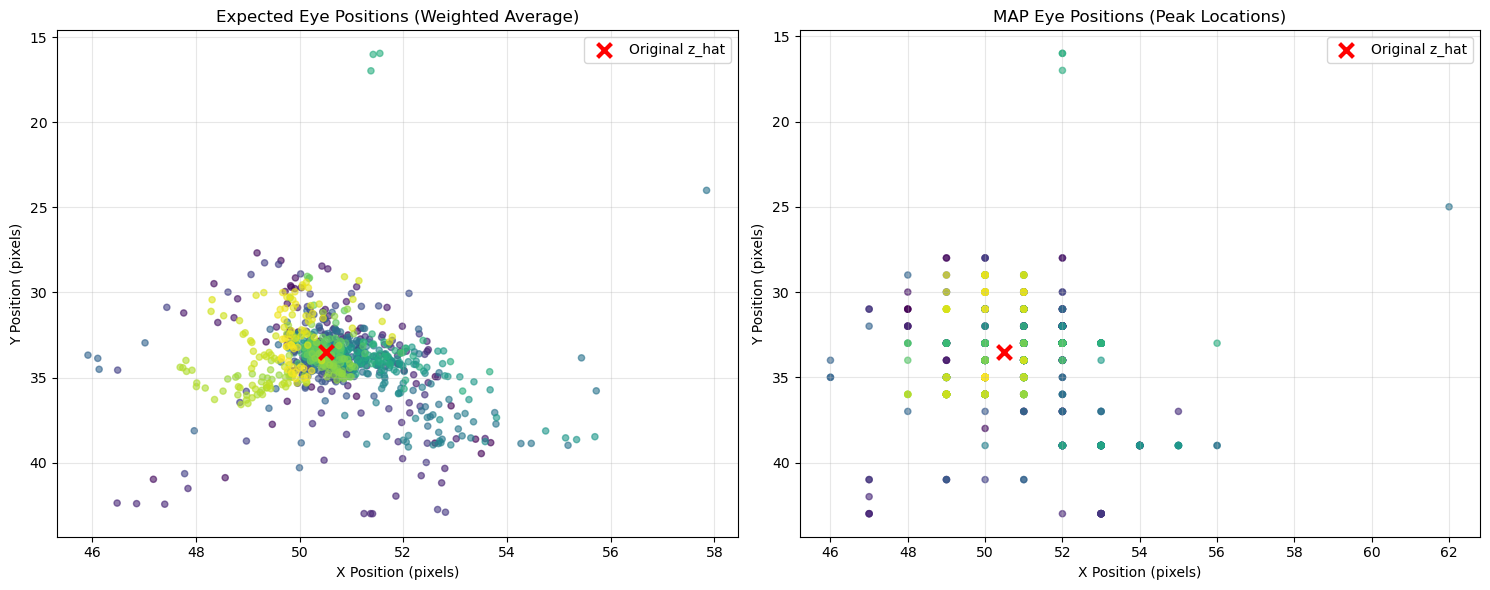


Distances from original z_hat:
Expected positions - Mean: 1.76, Std: 1.95
Peak positions - Mean: 2.40, Std: 2.06


In [25]:
# Create scatter plots of eye position estimates
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot expected positions (weighted average)
axes[0].scatter(expected_positions_np[:, 1], expected_positions_np[:, 0], 
               alpha=0.6, s=20, c=range(len(all_indices)), cmap='viridis')
axes[0].scatter(z_hat[1].cpu(), z_hat[0].cpu(), 
               color='red', s=100, marker='x', linewidth=3, label='Original z_hat')
axes[0].set_xlabel('X Position (pixels)')
axes[0].set_ylabel('Y Position (pixels)')
axes[0].set_title('Expected Eye Positions (Weighted Average)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].invert_yaxis()

# Plot MAP positions (peak locations)
axes[1].scatter(peak_positions_np[:, 1], peak_positions_np[:, 0], 
               alpha=0.6, s=20, c=range(len(all_indices)), cmap='viridis')
axes[1].scatter(z_hat[1].cpu(), z_hat[0].cpu(), 
               color='red', s=100, marker='x', linewidth=3, label='Original z_hat')
axes[1].set_xlabel('X Position (pixels)')
axes[1].set_ylabel('Y Position (pixels)')
axes[1].set_title('MAP Eye Positions (Peak Locations)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Calculate distances from original z_hat
expected_distances = np.sqrt(np.sum((expected_positions_np - z_hat.cpu().numpy()) ** 2, axis=1))
peak_distances = np.sqrt(np.sum((peak_positions_np - z_hat.cpu().numpy()) ** 2, axis=1))

print(f"\nDistances from original z_hat:")
print(f"Expected positions - Mean: {expected_distances.mean():.2f}, Std: {expected_distances.std():.2f}")
print(f"Peak positions - Mean: {peak_distances.mean():.2f}, Std: {peak_distances.std():.2f}")

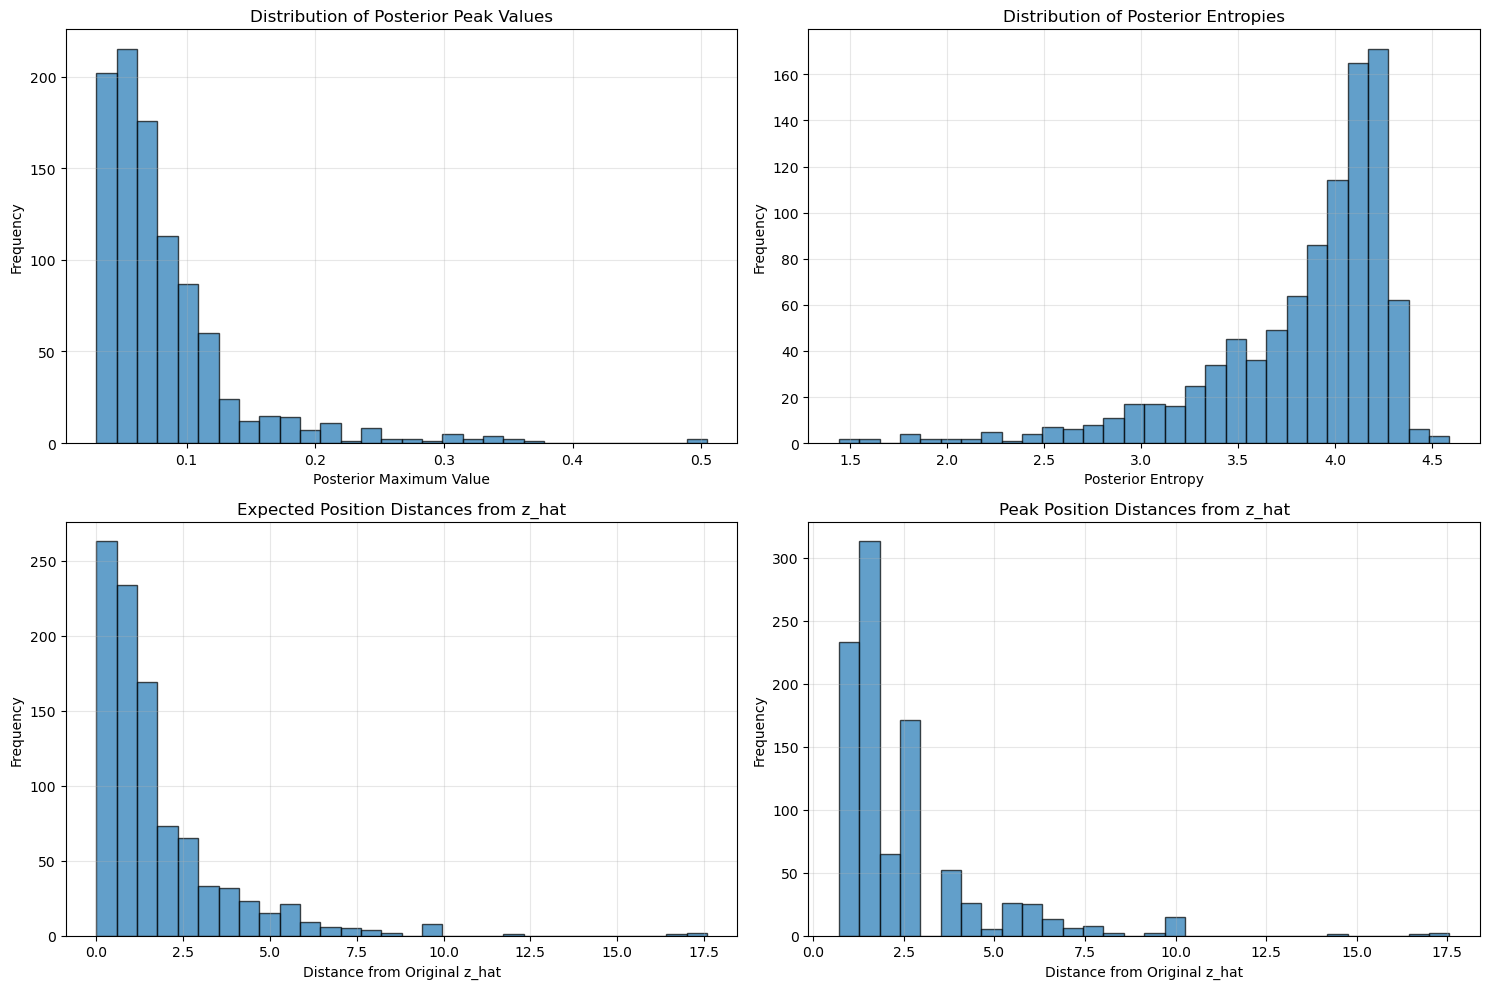

In [26]:
# Create histograms of posterior characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram of posterior maximum values
axes[0, 0].hist(posterior_maxes.cpu().numpy(), bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Posterior Maximum Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Posterior Peak Values')
axes[0, 0].grid(True, alpha=0.3)

# Histogram of posterior entropies
axes[0, 1].hist(posterior_entropies.cpu().numpy(), bins=30, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Posterior Entropy')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Posterior Entropies')
axes[0, 1].grid(True, alpha=0.3)

# Histogram of distances from z_hat (expected positions)
axes[1, 0].hist(expected_distances, bins=30, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Distance from Original z_hat')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Expected Position Distances from z_hat')
axes[1, 0].grid(True, alpha=0.3)

# Histogram of distances from z_hat (peak positions)
axes[1, 1].hist(peak_distances, bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Distance from Original z_hat')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Peak Position Distances from z_hat')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
with h5.File(h5_filepath, 'r') as f:
    # Extract series and epoch from test_series
    series_epoch = test_series[0]  # 'series_008/epoch_001'
    series_name, epoch_name = series_epoch.split('/')
    
    print(f"Examining test series: {series_name}, epoch: {epoch_name}")
    
    # Navigate to the specific series/epoch and print all signal keys
    epoch_group = f['data'][series_name][epoch_name]
    signals = epoch_group['signals']
    print(f"\nSignals available:")
    for signal_key in signals.keys():
        print(f"  {signal_key}: shape={signals[signal_key].shape}, dtype={signals[signal_key].dtype}")
    # Obtain dx and dy and store in a tensor
    dx = torch.tensor(signals['dx'][:], device=device, dtype=torch.float32)
    dy = torch.tensor(signals['dy'][:], device=device, dtype=torch.float32)

Examining test series: series_008, epoch: epoch_001

Signals available:
  azimuth: shape=(997,), dtype=float64
  blinks: shape=(997,), dtype=float64
  dx: shape=(997,), dtype=float64
  dy: shape=(997,), dtype=float64
  elevation: shape=(997,), dtype=float64
  gaze_mp4_frame_idxs: shape=(997,), dtype=float64
  interp_azimuth: shape=(997,), dtype=float64
  interp_elevation: shape=(997,), dtype=float64
  jackfish_pd: shape=(997,), dtype=float64
  locomotion: shape=(997,), dtype=float64
  nidaq_pd: shape=(997,), dtype=float64
  stimulus_frames: shape=(997,), dtype=int64


In [31]:
# Now, let's save dx and dy to the graph_data directory
torch.save(dx, os.path.join(graph_data_dir, 'dx.pt'))
torch.save(dy, os.path.join(graph_data_dir, 'dy.pt'))

In [43]:
# Load all the saved data from graph_data directory
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

# Load the saved data
graph_data_dir = './graph_data'
all_posteriors = torch.load(os.path.join(graph_data_dir, 'all_posteriors.pt'))
all_log_lkhds = torch.load(os.path.join(graph_data_dir, 'all_log_lkhds.pt'))
all_log_p_z_hat_given_z = torch.load(os.path.join(graph_data_dir, 'all_log_p_z_hat_given_z.pt'))
metadata = torch.load(os.path.join(graph_data_dir, 'metadata.pt'))
dx = torch.load(os.path.join(graph_data_dir, 'dx.pt'))
dy = torch.load(os.path.join(graph_data_dir, 'dy.pt'))

print(f"Loaded data shapes:")
print(f"  all_posteriors: {all_posteriors.shape}")
print(f"  all_log_lkhds: {all_log_lkhds.shape}")
print(f"  dx: {dx.shape}")
print(f"  dy: {dy.shape}")
print(f"  Grid shape: {metadata['grid_shape']}")

# Get grid dimensions and temporal parameters
H, W = metadata['grid_shape']
device = all_posteriors.device
num_before = 25  # From metadata or previous setup
num_after = 5

# The posteriors correspond to specific time bins in the dx/dy data
# We need to extract the corresponding dx/dy values for those time bins
num_response_timepoints = len(all_posteriors)
print(f"Number of neural response timepoints: {num_response_timepoints}")

# FIXED: dx and dy need to be offset by num_before=25 timepoints
# Neural response bins start at timepoint 25, so we align accordingly
dx_aligned = dx[num_before:num_before + num_response_timepoints]
dy_aligned = dy[num_before:num_before + num_response_timepoints]

print(f"\nTemporal alignment:")
print(f"  Total dx/dy length: {len(dx)}")
print(f"  Neural response starts at timepoint: {num_before}")
print(f"  Neural response ends at timepoint: {num_before + num_response_timepoints - 1}")
print(f"  Aligned dx shape: {dx_aligned.shape}")
print(f"  Aligned dy shape: {dy_aligned.shape}")
print(f"  Posterior/log_lkhd shape: {all_posteriors.shape}")

# Verify we have enough data
if num_before + num_response_timepoints > len(dx):
    print(f"WARNING: Not enough dx/dy data! Need {num_before + num_response_timepoints}, have {len(dx)}")
else:
    print(f"✓ Temporal alignment successful!")

Loaded data shapes:
  all_posteriors: torch.Size([966, 68, 102])
  all_log_lkhds: torch.Size([966, 6936])
  dx: torch.Size([997])
  dy: torch.Size([997])
  Grid shape: (68, 102)
Number of neural response timepoints: 966

Temporal alignment:
  Total dx/dy length: 997
  Neural response starts at timepoint: 25
  Neural response ends at timepoint: 990
  Aligned dx shape: torch.Size([966])
  Aligned dy shape: torch.Size([966])
  Posterior/log_lkhd shape: torch.Size([966, 68, 102])
✓ Temporal alignment successful!


/tmp/ipykernel_1034301/2789132205.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_posteriors = torch.load(os.path.join(graph_data_dir, 'all_posteriors.pt'))
/tmp/ipy

In [44]:
# Calculate expected eye positions from posterior distributions
print("Calculating expected positions from posteriors...")
expected_positions_posterior = torch.zeros((num_response_timepoints, 2), device=device)

# Define the center pixel position (around 34, 51 as mentioned)
center_y = H // 2  # Around 34
center_x = W // 2  # Around 51
print(f"Using center pixel: ({center_y}, {center_x})")

# Create coordinate grids
y_coords, x_coords = torch.meshgrid(
    torch.arange(H, device=device, dtype=torch.float32),
    torch.arange(W, device=device, dtype=torch.float32),
    indexing='ij'
)

for i in range(num_response_timepoints):
    posterior = all_posteriors[i]
    
    # Calculate expected position (weighted by posterior)
    expected_y = torch.sum(posterior * y_coords)
    expected_x = torch.sum(posterior * x_coords)
    
    # Subtract center pixel and add to ground truth trace
    # This accounts for the fact that the stimulus is already centered on the ground truth
    corrected_y = (expected_y - center_y) + dy_aligned[i]
    corrected_x = (expected_x - center_x) + dx_aligned[i]
    
    expected_positions_posterior[i, 0] = corrected_y
    expected_positions_posterior[i, 1] = corrected_x

print("Calculating expected positions from log-likelihoods...")
expected_positions_lkhd = torch.zeros((num_response_timepoints, 2), device=device)

# Normalize log likelihoods to get probability distributions
for i in range(num_response_timepoints):
    log_lkhd = all_log_lkhds[i].reshape(H, W)
    
    # Convert log likelihood to probability (softmax)
    # Subtract max for numerical stability
    log_lkhd_stable = log_lkhd - torch.max(log_lkhd)
    prob_lkhd = torch.exp(log_lkhd_stable)
    prob_lkhd = prob_lkhd / torch.sum(prob_lkhd)  # Normalize
    
    # Calculate expected position
    expected_y = torch.sum(prob_lkhd * y_coords)
    expected_x = torch.sum(prob_lkhd * x_coords)
    
    # Subtract center pixel and add to ground truth trace
    corrected_y = (expected_y - center_y) + dy_aligned[i]
    corrected_x = (expected_x - center_x) + dx_aligned[i]
    
    expected_positions_lkhd[i, 0] = corrected_y
    expected_positions_lkhd[i, 1] = corrected_x

print("Expected position calculations completed!")
print(f"Expected positions posterior shape: {expected_positions_posterior.shape}")
print(f"Expected positions lkhd shape: {expected_positions_lkhd.shape}")

Calculating expected positions from posteriors...
Using center pixel: (34, 51)
Calculating expected positions from log-likelihoods...
Calculating expected positions from log-likelihoods...
Expected position calculations completed!
Expected positions posterior shape: torch.Size([966, 2])
Expected positions lkhd shape: torch.Size([966, 2])
Expected position calculations completed!
Expected positions posterior shape: torch.Size([966, 2])
Expected positions lkhd shape: torch.Size([966, 2])


In [45]:
# Calculate standard deviations from posterior distributions
print("Calculating standard deviations from posteriors...")
std_positions_posterior = torch.zeros((num_response_timepoints, 2), device=device)

for i in range(num_response_timepoints):
    posterior = all_posteriors[i]
    
    # Use the corrected expected positions as means
    mean_y = expected_positions_posterior[i, 0]
    mean_x = expected_positions_posterior[i, 1]
    
    # Create coordinate grids centered on ground truth
    y_coords_centered = y_coords - center_y + dy_aligned[i]
    x_coords_centered = x_coords - center_x + dx_aligned[i]
    
    # Calculate variance for each dimension
    var_y = torch.sum(posterior * (y_coords_centered - mean_y)**2)
    var_x = torch.sum(posterior * (x_coords_centered - mean_x)**2)
    
    std_positions_posterior[i, 0] = torch.sqrt(var_y)
    std_positions_posterior[i, 1] = torch.sqrt(var_x)

print("Calculating standard deviations from log-likelihoods...")
std_positions_lkhd = torch.zeros((num_response_timepoints, 2), device=device)

for i in range(num_response_timepoints):
    log_lkhd = all_log_lkhds[i].reshape(H, W)
    
    # Convert to probability distribution
    log_lkhd_stable = log_lkhd - torch.max(log_lkhd)
    prob_lkhd = torch.exp(log_lkhd_stable)
    prob_lkhd = prob_lkhd / torch.sum(prob_lkhd)
    
    # Use the corrected expected positions as means
    mean_y = expected_positions_lkhd[i, 0]
    mean_x = expected_positions_lkhd[i, 1]
    
    # Create coordinate grids centered on ground truth
    y_coords_centered = y_coords - center_y + dy_aligned[i]
    x_coords_centered = x_coords - center_x + dx_aligned[i]
    
    # Calculate variance for each dimension
    var_y = torch.sum(prob_lkhd * (y_coords_centered - mean_y)**2)
    var_x = torch.sum(prob_lkhd * (x_coords_centered - mean_x)**2)
    
    std_positions_lkhd[i, 0] = torch.sqrt(var_y)
    std_positions_lkhd[i, 1] = torch.sqrt(var_x)

print("Standard deviation calculations completed!")
print(f"Standard deviations posterior shape: {std_positions_posterior.shape}")
print(f"Standard deviations lkhd shape: {std_positions_lkhd.shape}")

Calculating standard deviations from posteriors...
Calculating standard deviations from log-likelihoods...
Calculating standard deviations from log-likelihoods...
Standard deviation calculations completed!
Standard deviations posterior shape: torch.Size([966, 2])
Standard deviations lkhd shape: torch.Size([966, 2])
Standard deviation calculations completed!
Standard deviations posterior shape: torch.Size([966, 2])
Standard deviations lkhd shape: torch.Size([966, 2])


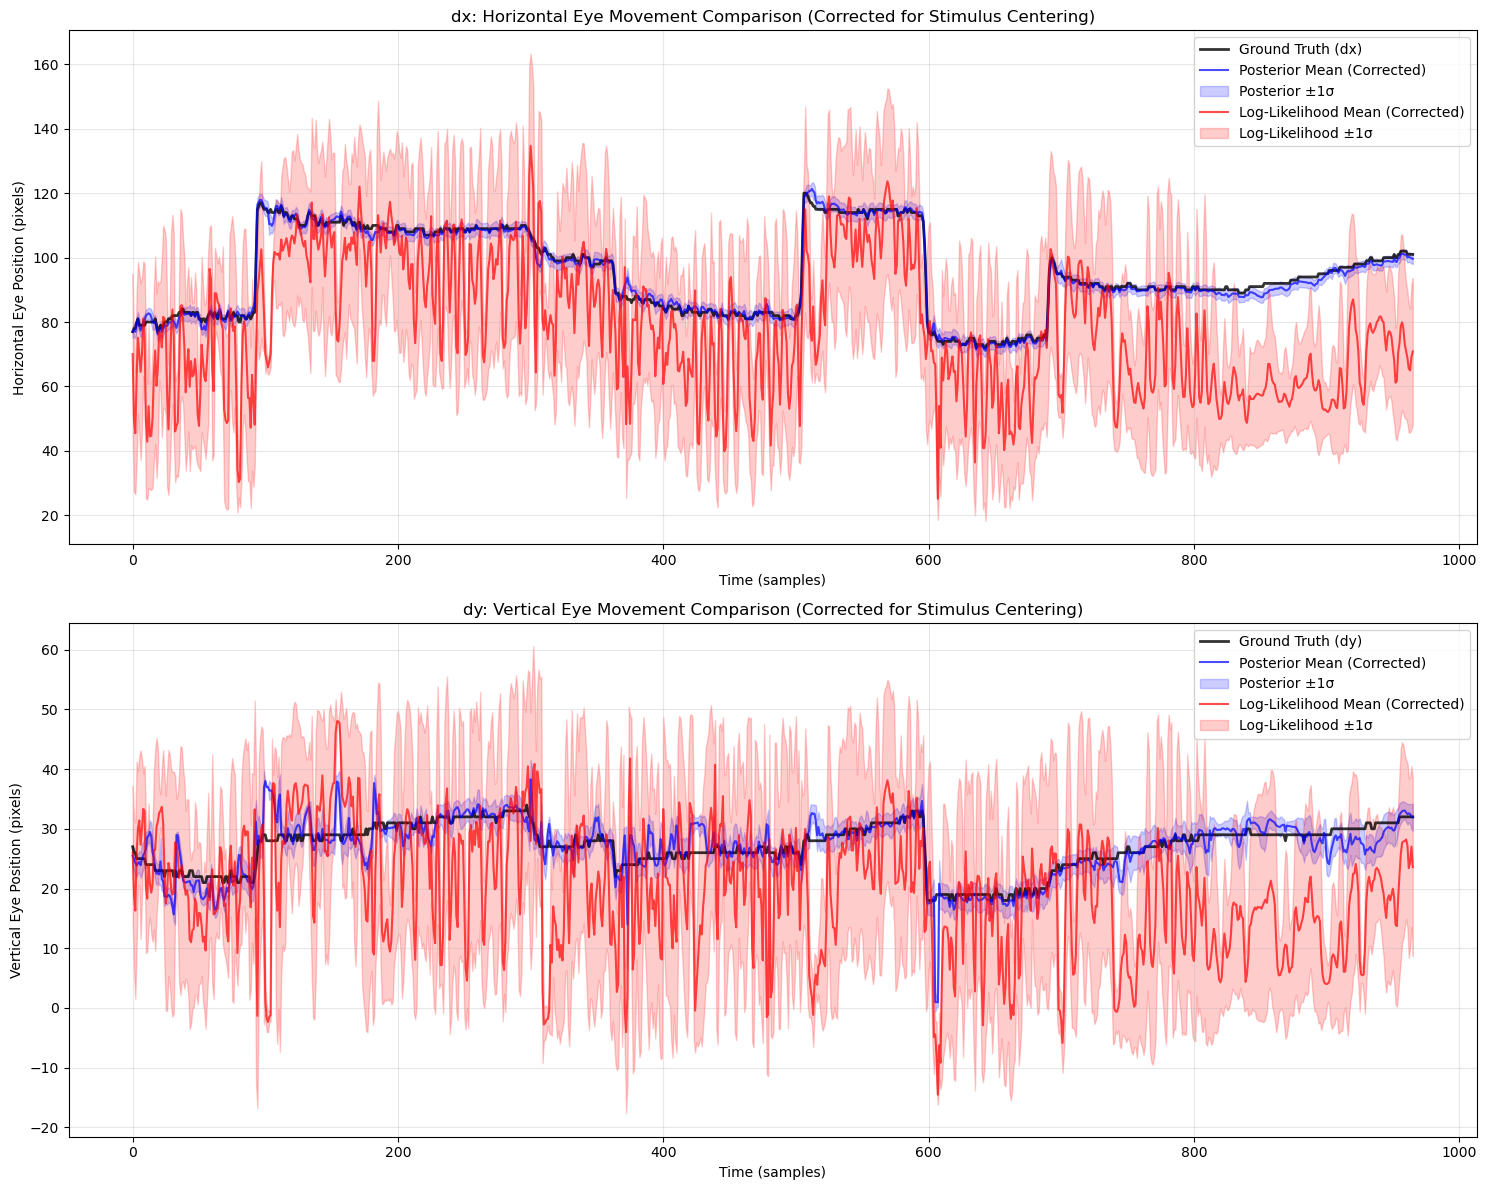


Correlation Analysis:
dx correlations:
  Posterior vs Ground Truth: 0.9961
  Log-Likelihood vs Ground Truth: 0.7056
dy correlations:
  Posterior vs Ground Truth: 0.8737
  Log-Likelihood vs Ground Truth: 0.2577

RMSE Analysis:
dx RMSE:
  Posterior: 1.2056 pixels
  Log-Likelihood: 21.9697 pixels
dy RMSE:
  Posterior: 2.3098 pixels
  Log-Likelihood: 12.2083 pixels

Note: Estimates are now corrected for stimulus centering.
Model predictions subtract center pixel (34, 51) and add to ground truth trace.


In [46]:
# Create comprehensive comparison plots for dx and dy
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Convert to numpy for plotting
time_points = np.arange(len(dx_aligned))
dx_np = dx_aligned.cpu().numpy()
dy_np = dy_aligned.cpu().numpy()

# Corrected estimates (accounting for stimulus centering)
expected_x_posterior = expected_positions_posterior[:, 1].cpu().numpy()
expected_y_posterior = expected_positions_posterior[:, 0].cpu().numpy()
std_x_posterior = std_positions_posterior[:, 1].cpu().numpy()
std_y_posterior = std_positions_posterior[:, 0].cpu().numpy()

# Log-likelihood estimates (corrected)
expected_x_lkhd = expected_positions_lkhd[:, 1].cpu().numpy()
expected_y_lkhd = expected_positions_lkhd[:, 0].cpu().numpy()
std_x_lkhd = std_positions_lkhd[:, 1].cpu().numpy()
std_y_lkhd = std_positions_lkhd[:, 0].cpu().numpy()

# Plot dx (horizontal eye movement)
axes[0].plot(time_points, dx_np, 'k-', linewidth=2, label='Ground Truth (dx)', alpha=0.8)

# Posterior estimates with error bars
axes[0].plot(time_points, expected_x_posterior, 'b-', linewidth=1.5, label='Posterior Mean (Corrected)', alpha=0.7)
axes[0].fill_between(time_points, 
                     expected_x_posterior - std_x_posterior, 
                     expected_x_posterior + std_x_posterior, 
                     color='blue', alpha=0.2, label='Posterior ±1σ')

# Log-likelihood estimates with error bars
axes[0].plot(time_points, expected_x_lkhd, 'r-', linewidth=1.5, label='Log-Likelihood Mean (Corrected)', alpha=0.7)
axes[0].fill_between(time_points, 
                     expected_x_lkhd - std_x_lkhd, 
                     expected_x_lkhd + std_x_lkhd, 
                     color='red', alpha=0.2, label='Log-Likelihood ±1σ')

axes[0].set_xlabel('Time (samples)')
axes[0].set_ylabel('Horizontal Eye Position (pixels)')
axes[0].set_title('dx: Horizontal Eye Movement Comparison (Corrected for Stimulus Centering)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot dy (vertical eye movement)
axes[1].plot(time_points, dy_np, 'k-', linewidth=2, label='Ground Truth (dy)', alpha=0.8)

# Posterior estimates with error bars
axes[1].plot(time_points, expected_y_posterior, 'b-', linewidth=1.5, label='Posterior Mean (Corrected)', alpha=0.7)
axes[1].fill_between(time_points, 
                     expected_y_posterior - std_y_posterior, 
                     expected_y_posterior + std_y_posterior, 
                     color='blue', alpha=0.2, label='Posterior ±1σ')

# Log-likelihood estimates with error bars
axes[1].plot(time_points, expected_y_lkhd, 'r-', linewidth=1.5, label='Log-Likelihood Mean (Corrected)', alpha=0.7)
axes[1].fill_between(time_points, 
                     expected_y_lkhd - std_y_lkhd, 
                     expected_y_lkhd + std_y_lkhd, 
                     color='red', alpha=0.2, label='Log-Likelihood ±1σ')

axes[1].set_xlabel('Time (samples)')
axes[1].set_ylabel('Vertical Eye Position (pixels)')
axes[1].set_title('dy: Vertical Eye Movement Comparison (Corrected for Stimulus Centering)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print correlation statistics
print("\nCorrelation Analysis:")
print("=" * 50)
print(f"dx correlations:")
print(f"  Posterior vs Ground Truth: {np.corrcoef(dx_np, expected_x_posterior)[0,1]:.4f}")
print(f"  Log-Likelihood vs Ground Truth: {np.corrcoef(dx_np, expected_x_lkhd)[0,1]:.4f}")
print(f"dy correlations:")
print(f"  Posterior vs Ground Truth: {np.corrcoef(dy_np, expected_y_posterior)[0,1]:.4f}")
print(f"  Log-Likelihood vs Ground Truth: {np.corrcoef(dy_np, expected_y_lkhd)[0,1]:.4f}")

# Print RMSE statistics
rmse_dx_posterior = np.sqrt(np.mean((dx_np - expected_x_posterior)**2))
rmse_dx_lkhd = np.sqrt(np.mean((dx_np - expected_x_lkhd)**2))
rmse_dy_posterior = np.sqrt(np.mean((dy_np - expected_y_posterior)**2))
rmse_dy_lkhd = np.sqrt(np.mean((dy_np - expected_y_lkhd)**2))

print(f"\nRMSE Analysis:")
print(f"dx RMSE:")
print(f"  Posterior: {rmse_dx_posterior:.4f} pixels")
print(f"  Log-Likelihood: {rmse_dx_lkhd:.4f} pixels")
print(f"dy RMSE:")
print(f"  Posterior: {rmse_dy_posterior:.4f} pixels")
print(f"  Log-Likelihood: {rmse_dy_lkhd:.4f} pixels")

print(f"\nNote: Estimates are now corrected for stimulus centering.")
print(f"Model predictions subtract center pixel ({center_y}, {center_x}) and add to ground truth trace.")

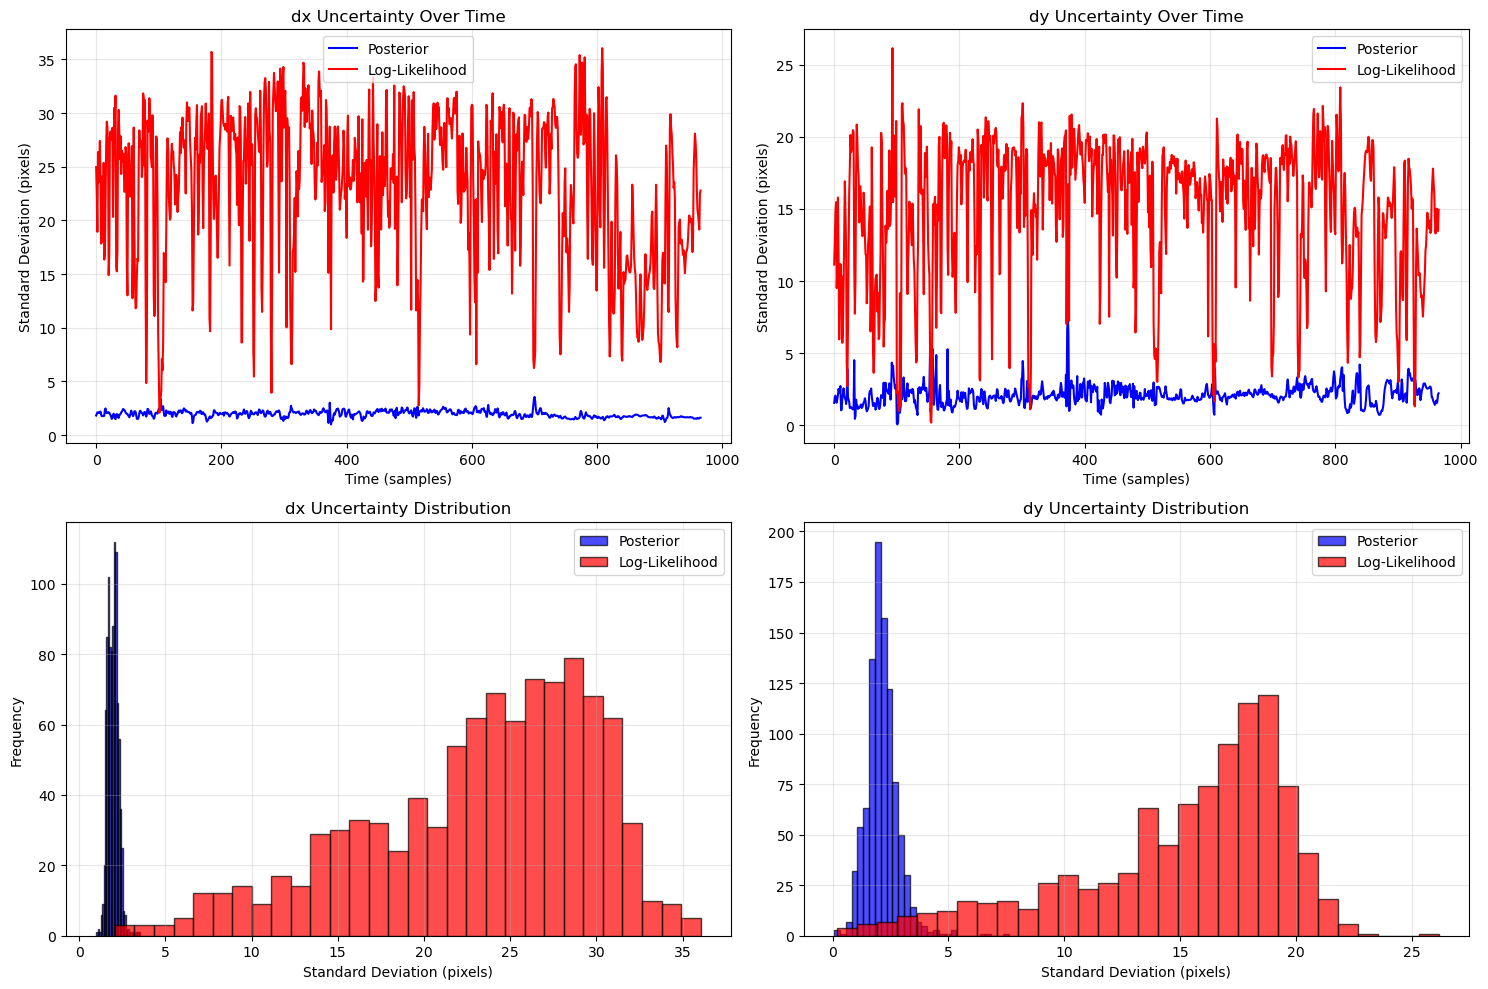


Uncertainty Analysis:
dx Standard Deviation:
  Posterior - Mean: 1.9559, Std: 0.3040
  Log-Likelihood - Mean: 23.2467, Std: 6.7240
dy Standard Deviation:
  Posterior - Mean: 2.1358, Std: 0.7016
  Log-Likelihood - Mean: 15.1118, Std: 4.6317


In [47]:
# Create uncertainty analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot standard deviations over time
axes[0, 0].plot(time_points, std_x_posterior, 'b-', label='Posterior', linewidth=1.5)
axes[0, 0].plot(time_points, std_x_lkhd, 'r-', label='Log-Likelihood', linewidth=1.5)
axes[0, 0].set_xlabel('Time (samples)')
axes[0, 0].set_ylabel('Standard Deviation (pixels)')
axes[0, 0].set_title('dx Uncertainty Over Time')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(time_points, std_y_posterior, 'b-', label='Posterior', linewidth=1.5)
axes[0, 1].plot(time_points, std_y_lkhd, 'r-', label='Log-Likelihood', linewidth=1.5)
axes[0, 1].set_xlabel('Time (samples)')
axes[0, 1].set_ylabel('Standard Deviation (pixels)')
axes[0, 1].set_title('dy Uncertainty Over Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Histogram of uncertainties
axes[1, 0].hist(std_x_posterior, bins=30, alpha=0.7, label='Posterior', color='blue', edgecolor='black')
axes[1, 0].hist(std_x_lkhd, bins=30, alpha=0.7, label='Log-Likelihood', color='red', edgecolor='black')
axes[1, 0].set_xlabel('Standard Deviation (pixels)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('dx Uncertainty Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(std_y_posterior, bins=30, alpha=0.7, label='Posterior', color='blue', edgecolor='black')
axes[1, 1].hist(std_y_lkhd, bins=30, alpha=0.7, label='Log-Likelihood', color='red', edgecolor='black')
axes[1, 1].set_xlabel('Standard Deviation (pixels)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('dy Uncertainty Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print uncertainty statistics
print("\nUncertainty Analysis:")
print("=" * 50)
print(f"dx Standard Deviation:")
print(f"  Posterior - Mean: {np.mean(std_x_posterior):.4f}, Std: {np.std(std_x_posterior):.4f}")
print(f"  Log-Likelihood - Mean: {np.mean(std_x_lkhd):.4f}, Std: {np.std(std_x_lkhd):.4f}")
print(f"dy Standard Deviation:")
print(f"  Posterior - Mean: {np.mean(std_y_posterior):.4f}, Std: {np.std(std_y_posterior):.4f}")
print(f"  Log-Likelihood - Mean: {np.mean(std_y_lkhd):.4f}, Std: {np.std(std_y_lkhd):.4f}")

In [48]:
# Save the analysis results for future use
analysis_results = {
    'expected_positions_posterior': expected_positions_posterior,
    'expected_positions_lkhd': expected_positions_lkhd,
    'std_positions_posterior': std_positions_posterior,
    'std_positions_lkhd': std_positions_lkhd,
    'dx_aligned': dx_aligned,
    'dy_aligned': dy_aligned,
    'correlations': {
        'dx_posterior': np.corrcoef(dx_np, expected_x_posterior)[0,1],
        'dx_lkhd': np.corrcoef(dx_np, expected_x_lkhd)[0,1],
        'dy_posterior': np.corrcoef(dy_np, expected_y_posterior)[0,1],
        'dy_lkhd': np.corrcoef(dy_np, expected_y_lkhd)[0,1]
    },
    'rmse': {
        'dx_posterior': rmse_dx_posterior,
        'dx_lkhd': rmse_dx_lkhd,
        'dy_posterior': rmse_dy_posterior,
        'dy_lkhd': rmse_dy_lkhd
    }
}

torch.save(analysis_results, os.path.join(graph_data_dir, 'eye_movement_analysis_simple.pt'))
print(f"\nSimplified analysis results saved to {os.path.join(graph_data_dir, 'eye_movement_analysis_simple.pt')}")
print(f"File size: {os.path.getsize(os.path.join(graph_data_dir, 'eye_movement_analysis_simple.pt')) / 1024:.2f} KB")

# Summary of key findings
print(f"\n" + "="*70)
print("SUMMARY OF KEY FINDINGS")
print("="*70)
print(f"Data alignment:")
print(f"  • {num_response_timepoints} response timepoints")
print(f"  • dx/dy aligned with neural response time bins")

print(f"\nBest Performing Method (by correlation with ground truth):")
dx_best = "Posterior" if analysis_results['correlations']['dx_posterior'] > analysis_results['correlations']['dx_lkhd'] else "Log-Likelihood"
dy_best = "Posterior" if analysis_results['correlations']['dy_posterior'] > analysis_results['correlations']['dy_lkhd'] else "Log-Likelihood"
print(f"  • dx (horizontal): {dx_best} (r = {max(analysis_results['correlations']['dx_posterior'], analysis_results['correlations']['dx_lkhd']):.4f})")
print(f"  • dy (vertical): {dy_best} (r = {max(analysis_results['correlations']['dy_posterior'], analysis_results['correlations']['dy_lkhd']):.4f})")

print(f"\nRMSE (lower is better):")
print(f"  • dx: Posterior = {analysis_results['rmse']['dx_posterior']:.4f}, Log-Likelihood = {analysis_results['rmse']['dx_lkhd']:.4f}")
print(f"  • dy: Posterior = {analysis_results['rmse']['dy_posterior']:.4f}, Log-Likelihood = {analysis_results['rmse']['dy_lkhd']:.4f}")


Simplified analysis results saved to ./graph_data/eye_movement_analysis_simple.pt
File size: 41.40 KB

SUMMARY OF KEY FINDINGS
Data alignment:
  • 966 response timepoints
  • dx/dy aligned with neural response time bins

Best Performing Method (by correlation with ground truth):
  • dx (horizontal): Posterior (r = 0.9961)
  • dy (vertical): Posterior (r = 0.8737)

RMSE (lower is better):
  • dx: Posterior = 1.2056, Log-Likelihood = 21.9697
  • dy: Posterior = 2.3098, Log-Likelihood = 12.2083


## Scratch below this

In [13]:
# Check data types before E_step
print(f"stim dtype: {stim.dtype}")
print(f"response dtype: {response.dtype}")

# Convert to float32 to match model weights
stim = stim.float()
response = response.float()

q_z_prior = torch.ones((H, W), device=device) / (H * W)  # Uniform prior over pixels
z_hat = torch.tensor([H/2-0.5, W/2-0.5], device=device)  # Put z_hat on the correct device
q_z, log_lkhd, log_p_z_hat_given_z = utils.E_step(stim, response, z_hat, model, q_z_prior, sigma=2.0, device=device)

stim dtype: torch.float64
response dtype: torch.float64


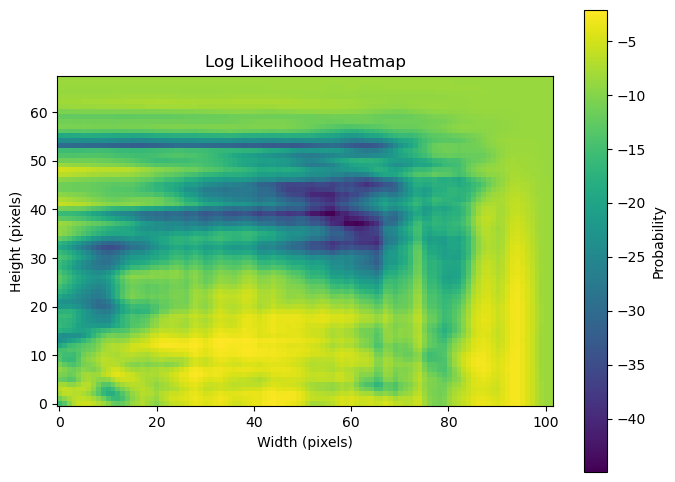

In [14]:
log_lkhd = log_lkhd.reshape(H, W)
# Plot log_lkhd as a 2D heatmap
utils.plot_distribution(log_lkhd, title="Log Likelihood Heatmap", flip_y=True, cmap='viridis')

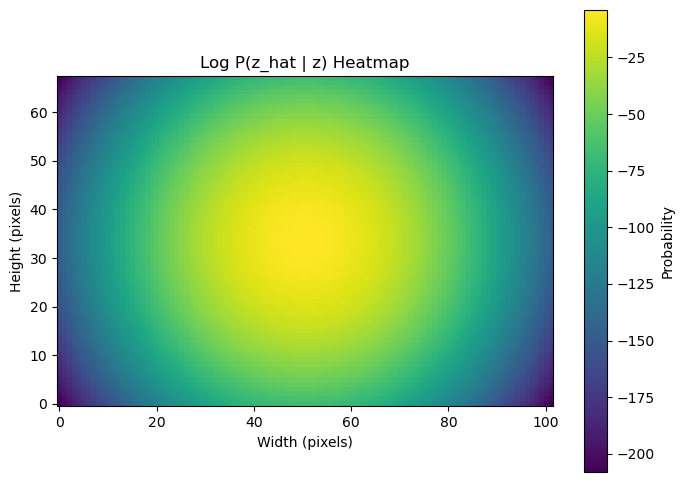

In [15]:
log_p_z_hat_given_z = log_p_z_hat_given_z.reshape(H, W)
# Plot log_p_z_hat_given_z as a 2D heatmap
utils.plot_distribution(log_p_z_hat_given_z, title="Log P(z_hat | z) Heatmap", flip_y=True, cmap='viridis')

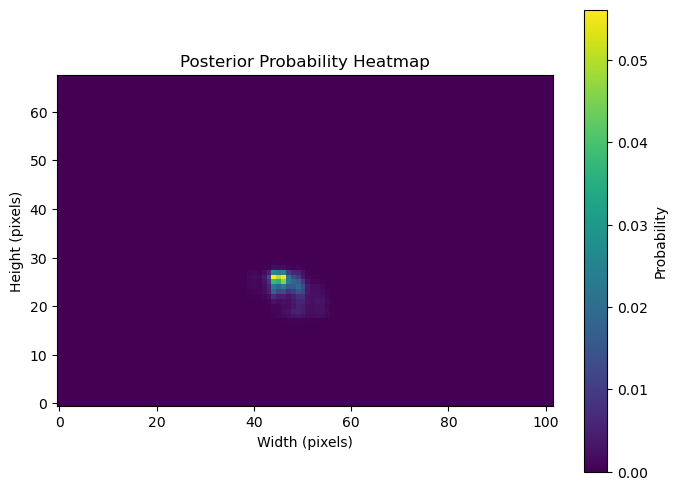

q_z shape: torch.Size([68, 102])
q_z sum: 1.000000
q_z max: 0.056157
q_z min: 0.000000


In [16]:
# Plot q_z as a 2D heatmap
utils.plot_distribution(q_z, title="Posterior Probability Heatmap", flip_y=True, cmap='viridis')

# Print some statistics
print(f"q_z shape: {q_z.shape}")
print(f"q_z sum: {q_z.sum().item():.6f}")
print(f"q_z max: {q_z.max().item():.6f}")
print(f"q_z min: {q_z.min().item():.6f}")

Step 1/10, Loss: 9.1398
Step 2/10, Loss: 2.0744
Step 3/10, Loss: 1.3350
Step 4/10, Loss: 1.0659
Step 5/10, Loss: 0.2231
Step 6/10, Loss: 0.4438
Step 7/10, Loss: 0.5506
Step 8/10, Loss: 0.3933
Step 9/10, Loss: 0.1920
Step 10/10, Loss: 0.0546


Text(0, 0.5, 'ELBO')

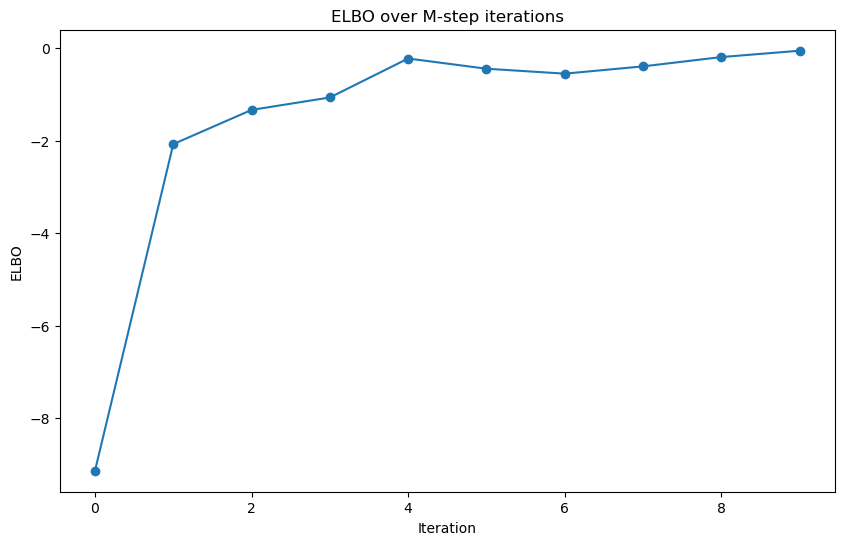

In [17]:
# Run the M step
model, elbos, lr = utils.M_step(stim, response, q_z, model, lr=1e-3, steps=10, device=device)
# Plot the ELBO over steps
plt.figure(figsize=(10, 6))
plt.plot(elbos, marker='o')
plt.title('ELBO over M-step iterations')
plt.xlabel('Iteration')
plt.ylabel('ELBO')

In [18]:
# Run E step again after M step
q_z, log_lkhd, log_p_z_hat_given_z = utils.E_step(stim, response, z_hat, model, q_z, sigma=2.0, device=device)

In [19]:
# Print the shapes
print(f"q_z shape after M step: {q_z.shape}")
print(f"log_lkhd shape after M step: {log_lkhd.shape}")
print(f"log_p_z_hat_given_z shape after M step: {log_p_z_hat_given_z.shape}")

q_z shape after M step: torch.Size([68, 102])
log_lkhd shape after M step: torch.Size([6936])
log_p_z_hat_given_z shape after M step: torch.Size([6936])


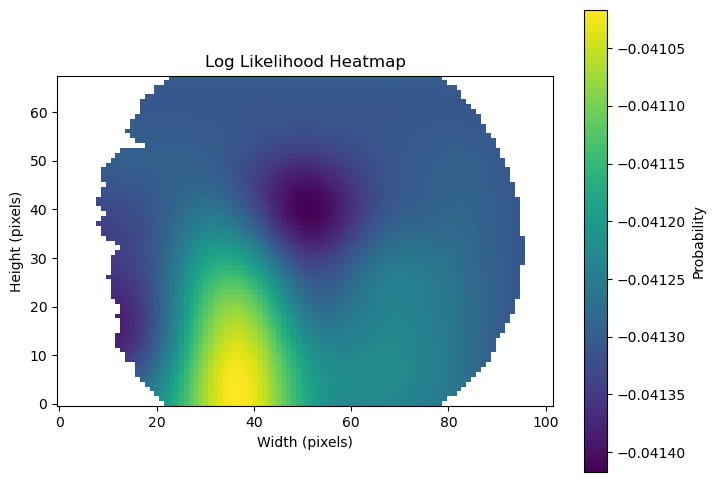

In [20]:
log_lkhd = log_lkhd.reshape(H, W)
# Plot log_lkhd as a 2D heatmap
utils.plot_distribution(log_lkhd, title="Log Likelihood Heatmap", flip_y=True, cmap='viridis')

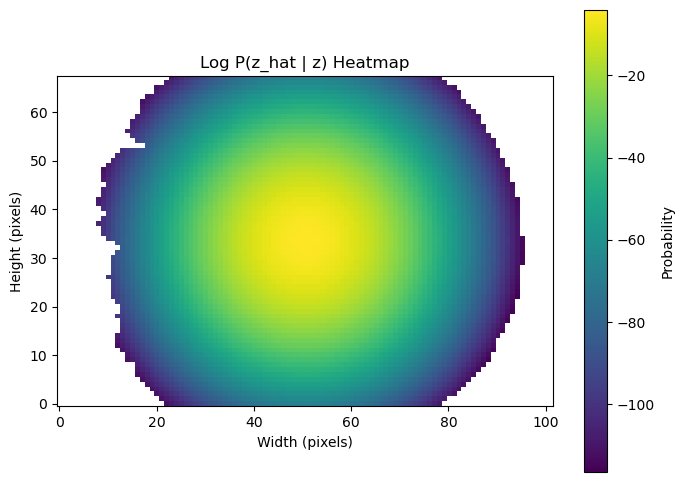

In [21]:
log_p_z_hat_given_z = log_p_z_hat_given_z.reshape(H, W)
# Plot log_p_z_hat_given_z as a 2D heatmap
utils.plot_distribution(log_p_z_hat_given_z, title="Log P(z_hat | z) Heatmap", flip_y=True, cmap='viridis')

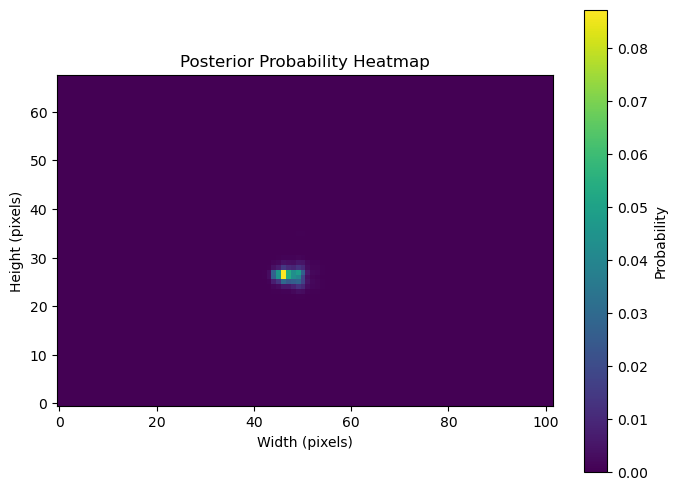

q_z shape: torch.Size([68, 102])
q_z sum: 1.000000
q_z max: 0.087209
q_z min: 0.000000


In [22]:
# Plot q_z as a 2D heatmap
utils.plot_distribution(q_z, title="Posterior Probability Heatmap", flip_y=True, cmap='viridis')

# Print some statistics
print(f"q_z shape: {q_z.shape}")
print(f"q_z sum: {q_z.sum().item():.6f}")
print(f"q_z max: {q_z.max().item():.6f}")
print(f"q_z min: {q_z.min().item():.6f}")

Step 1/10, Loss: 0.0430
Step 2/10, Loss: 76.8573
Step 3/10, Loss: 4.0931
Step 4/10, Loss: 2.9352
Step 5/10, Loss: 2.3070
Step 6/10, Loss: 2.2369
Step 7/10, Loss: 2.1875
Step 8/10, Loss: 2.1782
Step 9/10, Loss: 2.1733
Step 10/10, Loss: 2.1738


Text(0, 0.5, 'ELBO')

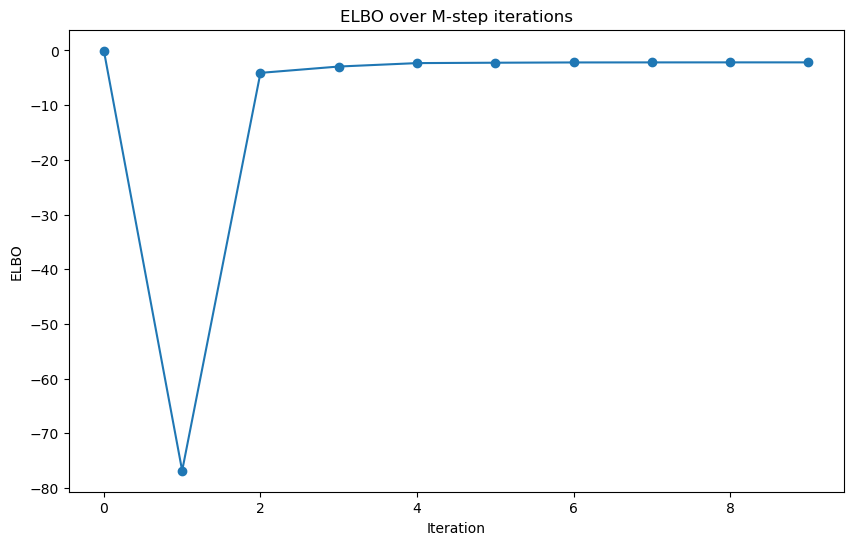

In [23]:
# Do it again
# Run the M step
model, elbos, lr = utils.M_step(stim, response, q_z, model, lr=1e-3, steps=10, device=device)
# Plot the ELBO over steps
plt.figure(figsize=(10, 6))
plt.plot(elbos, marker='o')
plt.title('ELBO over M-step iterations')
plt.xlabel('Iteration')
plt.ylabel('ELBO')

In [24]:
# Run E step again after M step
q_z, log_lkhd, log_p_z_hat_given_z = utils.E_step(stim, response, z_hat, model, q_z, sigma=2.0, device=device)

In [25]:
# Print the shapes
print(f"q_z shape after M step: {q_z.shape}")
print(f"log_lkhd shape after M step: {log_lkhd.shape}")
print(f"log_p_z_hat_given_z shape after M step: {log_p_z_hat_given_z.shape}")

q_z shape after M step: torch.Size([68, 102])
log_lkhd shape after M step: torch.Size([6936])
log_p_z_hat_given_z shape after M step: torch.Size([6936])


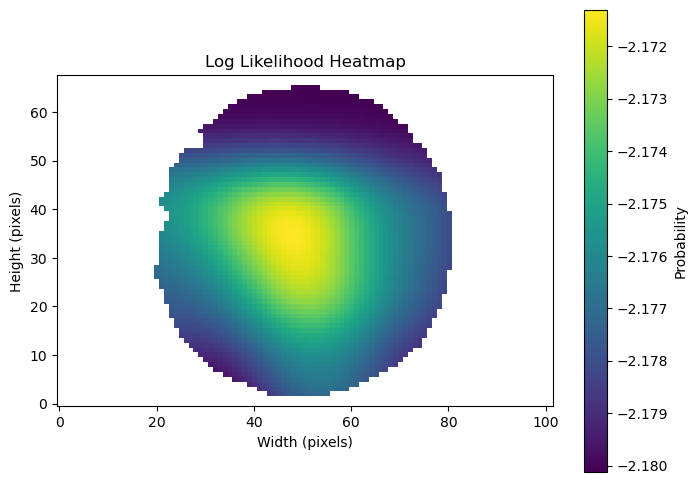

In [26]:
log_lkhd = log_lkhd.reshape(H, W)
# Plot log_lkhd as a 2D heatmap
utils.plot_distribution(log_lkhd, title="Log Likelihood Heatmap", flip_y=True, cmap='viridis')

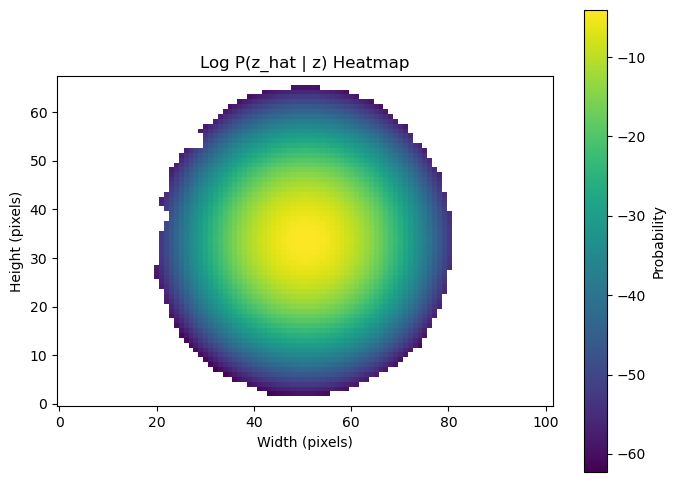

In [27]:
log_p_z_hat_given_z = log_p_z_hat_given_z.reshape(H, W)
# Plot log_p_z_hat_given_z as a 2D heatmap
utils.plot_distribution(log_p_z_hat_given_z, title="Log P(z_hat | z) Heatmap", flip_y=True, cmap='viridis')

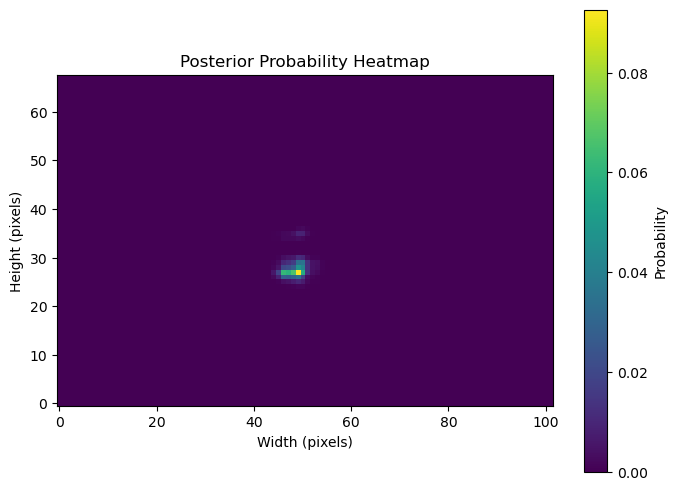

q_z shape: torch.Size([68, 102])
q_z sum: 1.000000
q_z max: 0.092703
q_z min: 0.000000


In [28]:
# Plot q_z as a 2D heatmap
utils.plot_distribution(q_z, title="Posterior Probability Heatmap", flip_y=True, cmap='viridis')

# Print some statistics
print(f"q_z shape: {q_z.shape}")
print(f"q_z sum: {q_z.sum().item():.6f}")
print(f"q_z max: {q_z.max().item():.6f}")
print(f"q_z min: {q_z.min().item():.6f}")